In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
import statsmodels.api as sm

In [38]:
from google.colab import files
dataset = files.upload()

Saving AAPL.csv to AAPL (1).csv


In [39]:
stock_data = pd.read_csv('AAPL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,27.847500,27.860001,26.157499,26.937500,24.144629,893572400
2015-01-08,27.307501,28.312500,27.125000,27.450001,24.603998,1115053200
2015-01-15,27.500000,27.764999,26.299999,27.387501,24.547976,948012400
2015-01-22,27.565001,29.530001,27.257500,28.827499,25.838676,1591688000
2015-01-29,29.080000,30.127501,28.889999,29.889999,26.791019,1411945600
...,...,...,...,...,...,...
2023-09-28,169.339996,174.300003,167.619995,173.660004,173.660004,262888000
2023-10-05,173.789993,179.850006,172.679993,179.800003,179.800003,239391900
2023-10-12,180.070007,182.339996,174.800003,175.839996,175.839996,273001000


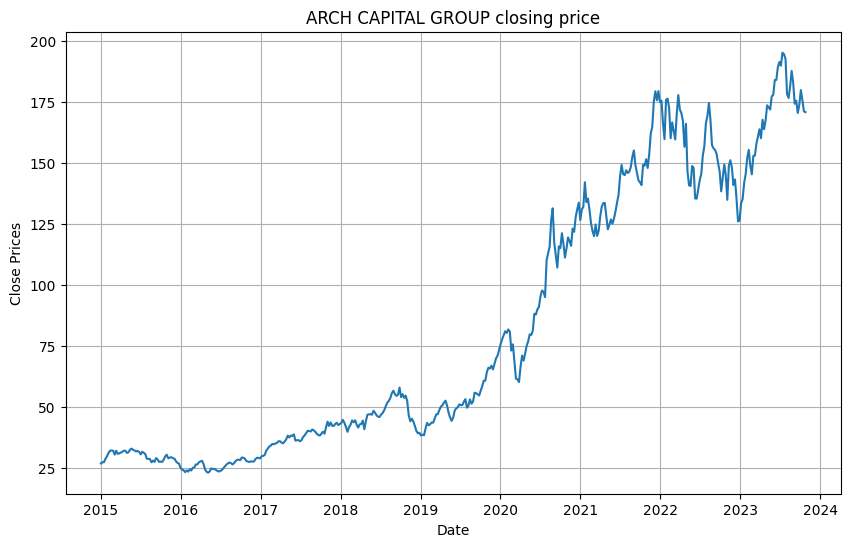

In [40]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

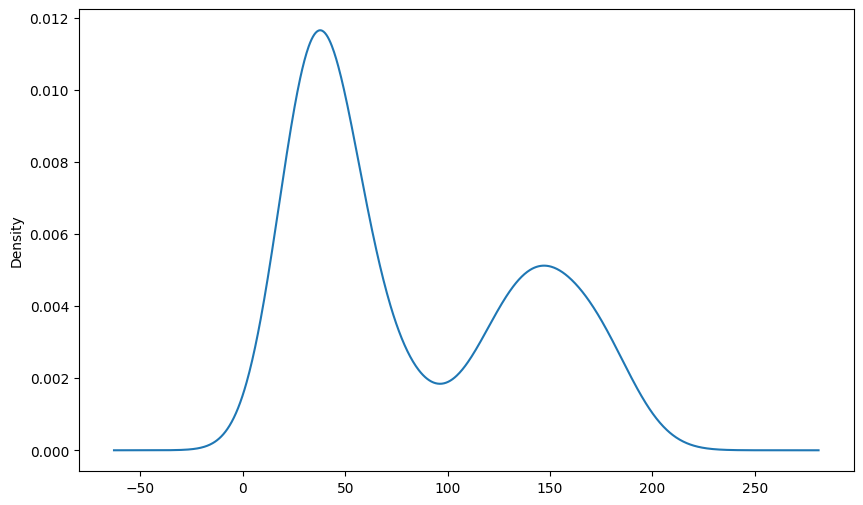

In [41]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

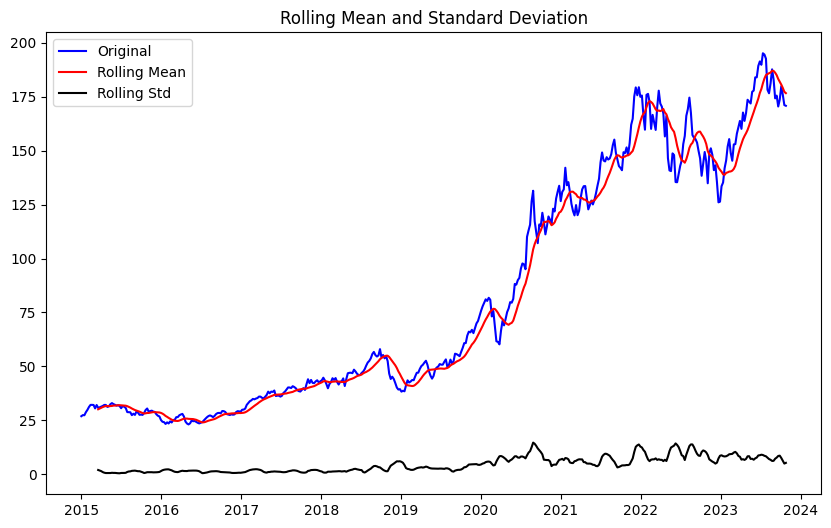

Results of dickey fuller test
Test Statistics                 -0.234638
p-value                          0.934265
No. of lags used                17.000000
Number of observations used    443.000000
critical value (1%)             -3.445198
critical value (5%)             -2.868086
critical value (10%)            -2.570257
dtype: float64


In [44]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

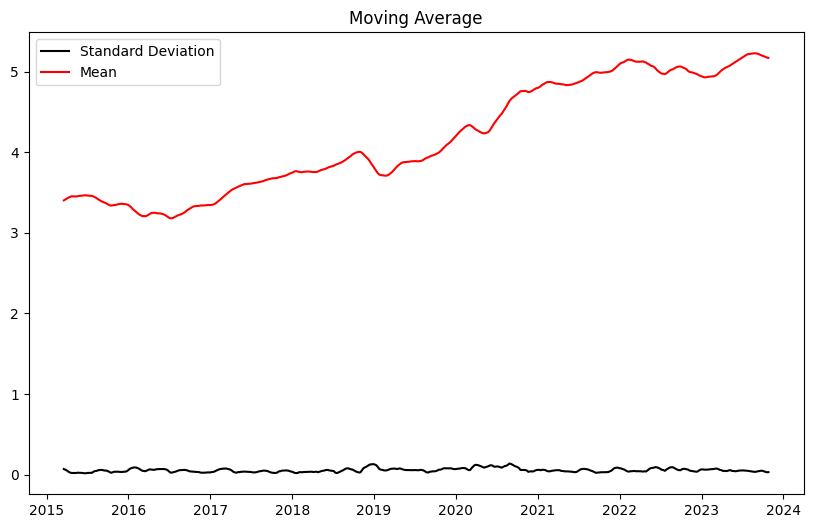

In [43]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

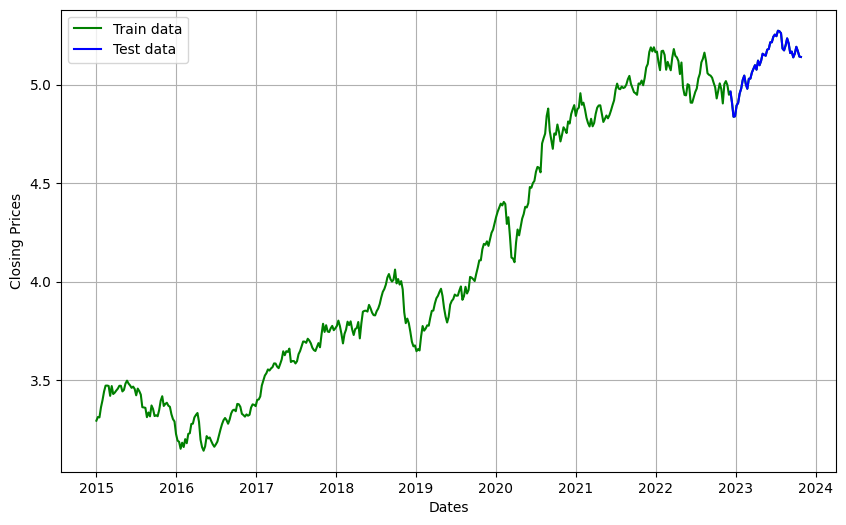

In [45]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1554.899, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1556.641, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1556.549, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1552.225, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1554.662, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1554.664, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1552.667, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1554.833, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.397 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  411
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 781.321
Date:                Wed, 08 Nov 2023   AIC                          -1556.641
Time:                       

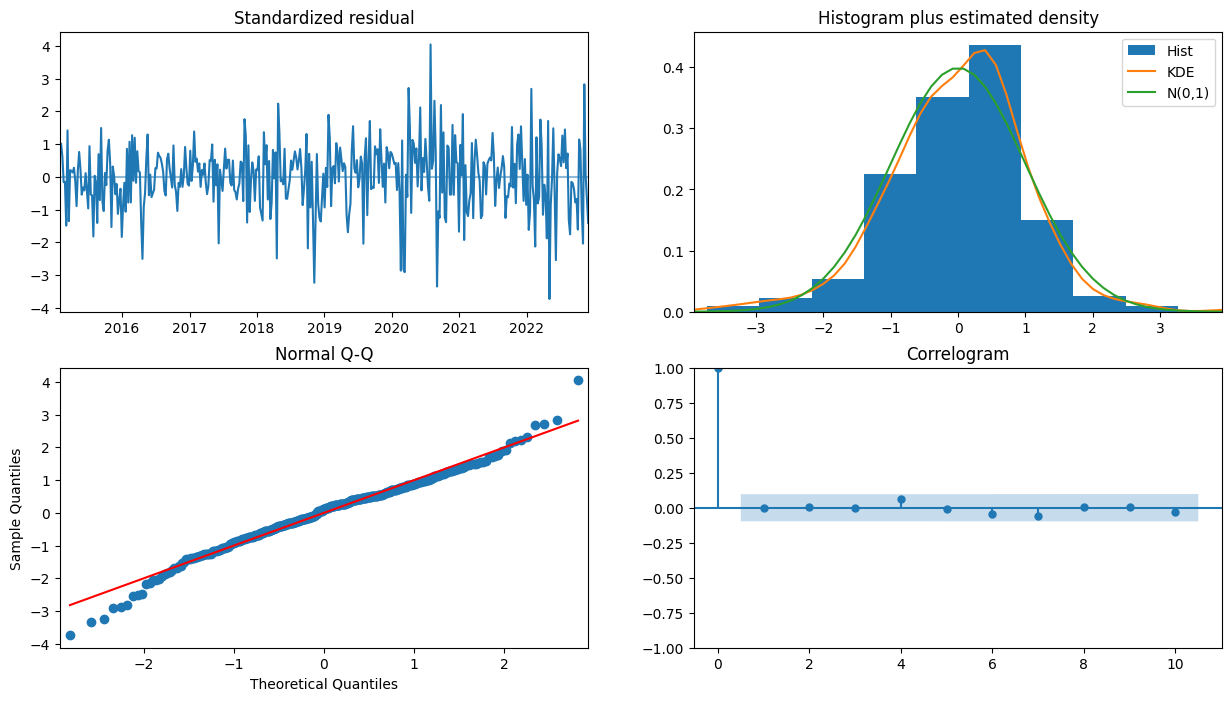

In [46]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [47]:
# Load the AAPL stock price data
price = pd.read_csv("AAPL.csv")
price['Date'] = pd.to_datetime(price['Date'])
price = price.sort_values(by='Date')

In [48]:
# Calculate the first differences of the stock prices
d1 = np.diff(price['Close'])
logd1 = np.diff(np.log(price['Close']))
sd1 = np.diff(np.sqrt(price['Close']))

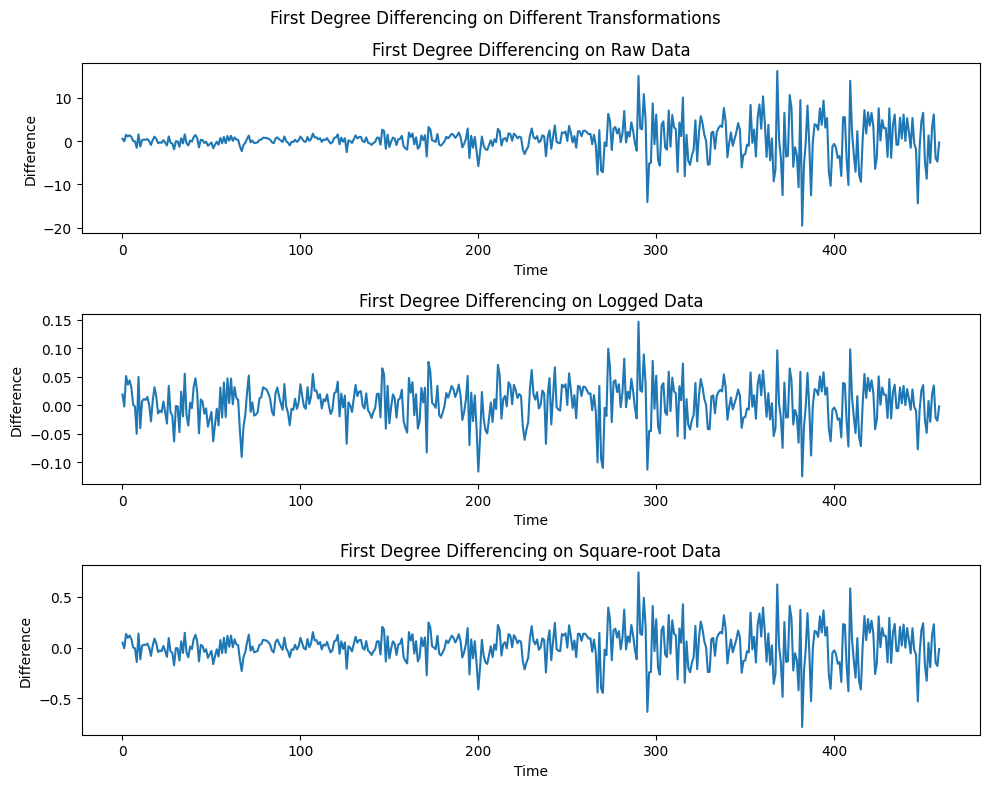

In [49]:
# Plot the first differences of the stock prices
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('First Degree Differencing on Different Transformations')

for i, data, title in zip(range(3), [d1, logd1, sd1], ['Raw Data', 'Logged Data', 'Square-root Data']):
    axes[i].plot(data)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Difference')
    axes[i].set_title(f'First Degree Differencing on {title}')

plt.tight_layout()
plt.show()

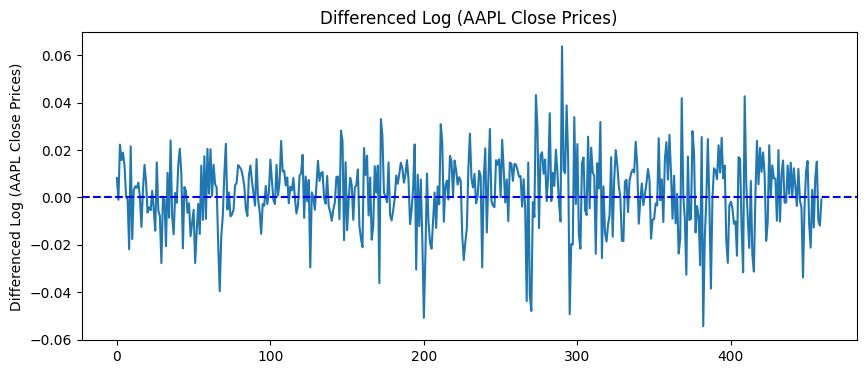

In [50]:
# Convert data to a Pandas DataFrame
stock_data = price['Close']
stock_data_df = pd.DataFrame({'Close': np.log10(stock_data)})

# Plot the differenced log of the data
plt.figure(figsize=(10, 4))
plt.plot(np.diff(np.log10(price['Close'])))
plt.axhline(0, color='blue', linestyle='--')
plt.ylabel('Differenced Log (AAPL Close Prices)')
plt.title('Differenced Log (AAPL Close Prices)')
plt.show()

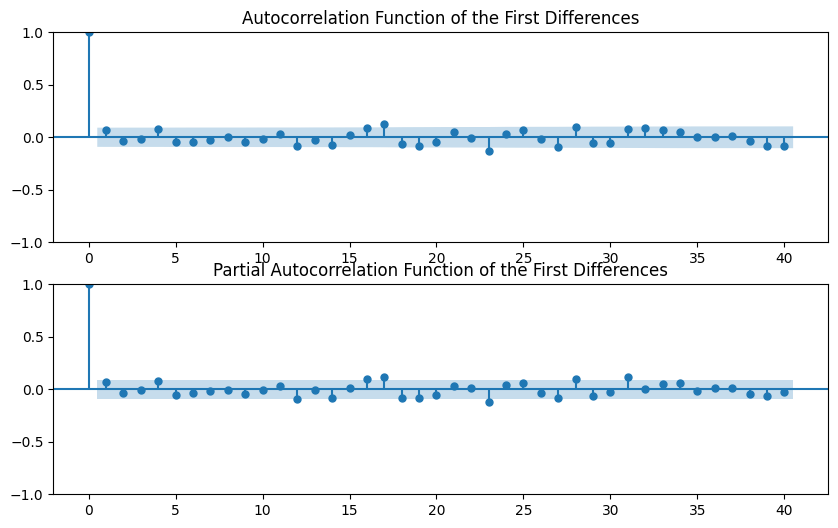

In [51]:
# Calculate and plot autocorrelation and partial autocorrelation functions
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(sd1, ax=axes[0], lags=40, title='Autocorrelation Function of the First Differences')
plot_pacf(sd1, ax=axes[1], lags=40, title='Partial Autocorrelation Function of the First Differences')
plt.show()

In [52]:
differenced_data = np.diff(price['Close'])

# Calculate autocorrelations up to lag 10
acf, q_stat, p_value = sm.tsa.acf(differenced_data, nlags=10, qstat=True)

# Perform Ljung-Box test
critical_values = sm.tsa.q_stat(q_stat, len(differenced_data))
lags = np.arange(1, 11)

for lag, p_val, crit_val in zip(lags, p_value, critical_values):
    print(f"Lag {lag}:")
    print(f"  p-value: {p_val}")
    print(f"  Critical value: {crit_val}")

Lag 1:
  p-value: 0.2779096380155731
  Critical value: [   641.7258245    4421.29913317   9637.41983425  28681.6365264
  55713.2583756   90182.85349681 124728.5898008  160049.34367424
 215931.68727284 272368.9528453 ]
Lag 2:
  p-value: 0.24002772722478896
  Critical value: [1.4079879e-141 0.0000000e+000 0.0000000e+000 0.0000000e+000
 0.0000000e+000 0.0000000e+000 0.0000000e+000 0.0000000e+000
 0.0000000e+000 0.0000000e+000]
